# Neural Recommender System
The Neural Recommender System is an extension of the (biased) Matrix Factorization, as it now includes one or multiple hidden layer units with activation functions, dropout and again weight decay. I trained and validated the Neural Recommender on the same training and validation dataset, respectively, as the other two models, with testing being done on the same testset to provide equal footing for all three models. The Neural Network architecture is simple with just one hidden layer of size ten, dropout of 0.1, and reLU activation function.

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Oct 05 01:22:46 2020

@author: Ufkun-Bayram Menderes

This Python Module contains the implementation of 
Neural Recommender Class and its training on the goodbooks10k dataset. The Neural
Recommender is implemented in PyTorch.
"""
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
# import the loaded test, validation and trainingsdata
from load_goodbooks_ds import *
from train import train_epochs, test_loss
from encode_books import proc_col, encode_data
from metrics import *




###############################################################################
# 1st part: Loading the goodbooks dataset from the load_goodbooks_ds.py file
# In that file, the dataset is alredy split up into training, validation and test
# sets. 
# train_ratings = Training set, valid_ratings = validation set, test_rating = 
# testset. The training set consists of 80% of the data in the goodbooks10k 
# dataset, while validation and training make up 10% each. 
###############################################################################


# number of users for embeddings = 53424
num_users = train_ratings.user_id.nunique()
# number of books = 10000
num_items = train_ratings.book_id.nunique()
# determine min and max ratings
min_rating = min(ratings["rating"])
max_rating = max(ratings["rating"])
second_highest = max_rating - 1

min_user_id = min(ratings["user_id"])
max_user_id = max(ratings["user_id"])

print("Number of users: {}, Number of books: {}, Min rating: {}, Max rating: {}"
      .format(num_users_total, num_items, min_rating, max_rating))

###############################################################################
# Now we create the RecommenderNet Class which is our Neural Recommender based 
# on a Neural Network with one hidden layer, reLu activation 
# for hidden layers, and default dropout of 0.01
###############################################################################


class RecommenderNet(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100, n_hidden=10):
        """
        PyTorch Module for Neural Recommender on goodbooks10k dataset

        Parameters
        ----------
        num_users : int
            number of unique users in the dataset
        num_items : int
            number of unique items(books) in the dataset
        emb_size : int, optional
            size of user-item embeddings. The default is 100.
        n_hidden : int, optional
            (output) size of hidden layers. The default is 10.
        

        Returns
        -------
        RecommenderNet object
        RecommenderNet object as Neural Recommender

        """
        super(RecommenderNet, self).__init__()
        # initialize embedding layers
        self.user_embedding = nn.Embedding(num_users, emb_size)
        self.item_embedding = nn.Embedding(num_items, emb_size)
        # initialize hidden layers and linear transformation
        self.hl1 = nn.Linear(emb_size*2, n_hidden)
        self.hl2 = nn.Linear(n_hidden, 1)
        # set dropout
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, user, item):
        """
        Forward pass for the Neural Recommender

        Parameters
        ----------
        user : int
            user_id, numerical representation of a user in the goodbooks dataset
        item : int
            book_id, numerical representation of a user 

        Returns
        -------
        x : torch.tensor
            Pytorch Tensor containing output of forward pass

        """
        user_vector = self.user_embedding(user)
        item_vector = self.item_embedding(item)
        x = F.relu(torch.cat([user_vector, item_vector], dim=1))
        x = self.dropout(x)
        x = F.relu(self.hl1(x))
        x = self.hl2(x)
        return x
    
    def recommend(self, userID, n=150, r=3):
        """
        Computes the recommendations for a user with collaborative filtering

        Parameters
        ----------
        userID : int
            user ID in the goodbooks dataset, must be be between 1 and
            53424
        n : int, optional
             number of recommendations returned by the system.
             The default is 10.
        
        r : int, optinal
            number of decimal places to which the predicted ratings are rounded 
            up to. The default is 3

        Returns
        -------
        recommended_books : pandas
            pandas dataframe containing user recommendation with predicted rating
            columns in order: id, 

        """
        # Verify that user is correct
        if userID > max_user_id or userID < min_user_id:
            raise ValueError("Invalid user ID")
        #load preprocessed books.csv file from goodbooks
        books = load_books()
        # create book vector for books
        books_vec = torch.tensor(ratings['book_id'].unique().tolist()) - 1
        # create user vector
        user_vec = torch.tensor([userID])
        # get shape of book vector
        books_shape = list(books_vec.shape)
        books_shape = books_shape[0]
        # resize user vector to a compatible size with book vector
        user_vec = torch.cat([user_vec]*books_shape)
        # compute ratings prediction for user by forwardpass
        predictions = self.forward(user_vec, books_vec)
        # make numpy array out of predictions
        predictions = np.array([a[0] for a in predictions])
        # get book id's into a list
        book_ids = ratings.book_id.unique()
        # convert predictions into a list with float elements
        predictions = predictions.tolist()
        # get predicted item ratings out of tensor elements
        # make a list out of the ratings
        predictions = [i.item() for i in predictions]
        # zip the book_ids and corresponding rating prediction to a list of 
        # (rating, id) tuples
        predictions = list(zip(predictions, book_ids))
        # get the books which the user has alread read
        user_books_read = ratings[ratings.user_id == userID]
        # make a list out of the book_id's that user has alread read
        read_list = list(user_books_read.book_id)
        # make an empty list for unread books, fill it with book_ids
        # of books that user has not rated/read yet
        unread_books = []
        for book in predictions:
            if book[1] not in read_list:
                unread_books.append(book)
        # sort the elements according to their rating, top ratings at top
        unread_books = sorted(unread_books, key=lambda book_tuple: book_tuple[0],
                              reverse=True)
        # indice the list on desired top n elements
        top_n_books = unread_books[:n]
        # get book_ids of top n elements
        top_n_book_ids = [books[1] for books in top_n_books]
        # get the full book information of these books from books.csv dataset
        recommended_books = books[books["id"].isin(top_n_book_ids)]
        # make dict out of top_n_books, keys=ratings, values=ids
        book_rating_dict = dict(top_n_books)
        # reverse keys and values s.t. ids are keys, ratings are values
        book_rating_dict = {value:key for key, value in book_rating_dict.items()}
        # make tuples out key, value elements, save them in the new list
        books_list_rev = [(k, v) for k, v in book_rating_dict.items()]
        # add a new dataframe with id, predicted rating tuples
        book_rating_tups = pd.DataFrame(books_list_rev, columns=['id','predicted_rating'])
        # merge both dataframes into one, id's column is common columns
        recommended_books = recommended_books.merge(book_rating_tups)
        # change predicted ratings >= 5.0 to 5
        recommended_books.loc[recommended_books['predicted_rating'] > 5.0, 'predicted_rating'] = 5.0
        # sort the predicted_rating column such that ratings with highest values
        # are at the top with descending order
        recommended_books = recommended_books.sort_values('predicted_rating', ascending=False)
        # round the values for predicted ratings
        recommended_books = recommended_books.round({'predicted_rating':r})
        # create new columns for predicted ratings on a 1-5 scale
        recommended_books['predicted_rating_scaled'] = recommended_books['predicted_rating']
        # round the ratings to zero decimal places so only values from 1-5 exist
        recommended_books = recommended_books.round({'predicted_rating_scaled':0})
        # return recommended books
        return recommended_books
        
        

# initialize the model by creating object of RecommenderNet class   
model = RecommenderNet(num_users, num_items, emb_size=100)
# train the model on test and validation dataset with weight decay
train_epochs(model, epochs=100, lr=0.01, wd=1e-6, unsqueeze=True)


# create test inputs and calculate test predictions
test_users = torch.LongTensor(test_ratings.user_id.values)
test_books = torch.LongTensor(test_ratings.book_id.values)
# test predictions are returned as torch.tensor object
test_predictions = model(test_users, test_books)
# make list out of test_predictions
test_predictions = test_predictions.tolist()
# round the predictions zero decimal places 
test_predictions = [ratings[0] for ratings in test_predictions]
test_predictions = list(np.around(test_predictions, 0))


Number of users: 53424, Number of books: 10000, Min rating: 1, Max rating: 5
Epoch:0, Loss:17.53957748413086
Epoch:1, Loss:12.964643478393555
Epoch:2, Loss:8.857156753540039
Epoch:3, Loss:5.309146404266357
Epoch:4, Loss:2.6900715827941895
Epoch:5, Loss:1.326866865158081
Epoch:6, Loss:1.3776589632034302
Epoch:7, Loss:2.4399001598358154
Epoch:8, Loss:3.467172384262085
Epoch:9, Loss:3.7803616523742676
Epoch:10, Loss:3.4083034992218018
Epoch:11, Loss:2.681684732437134
Epoch:12, Loss:1.9351897239685059
Epoch:13, Loss:1.386031150817871
Epoch:14, Loss:1.1143184900283813
Epoch:15, Loss:1.089106559753418
Epoch:16, Loss:1.2289141416549683
Epoch:17, Loss:1.4336835145950317
Epoch:18, Loss:1.621253252029419
Epoch:19, Loss:1.741132378578186
Epoch:20, Loss:1.7698665857315063
Epoch:21, Loss:1.7097876071929932
Epoch:22, Loss:1.5779837369918823
Epoch:23, Loss:1.4056493043899536
Epoch:24, Loss:1.2256267070770264
Epoch:25, Loss:1.0715367794036865
Epoch:26, Loss:0.9663290977478027
Epoch:27, Loss:0.92355984

As can be seen, the Neural Recommender provides the highest loss for training and validation, which may come as a surprise.

### Recommending items for a random user
Now, just, as before, I will recommend items to the randomly chosen user with id = 1500

In [3]:
model.recommend(2500)

,id,isbn,authors,year,title,avg_rating,predicted_rating,predicted_rating_scaled
75,7852,842339655,R.C. Sproul,1984.0,The Holiness of God,4.35,5.000,5.0
115,9076,402366174,The Church of Jesus Christ of Latter-day Saints,2004.0,Preach My Gospel: A Guide To Missionary Service,4.71,5.000,5.0
35,6527,163215711X,"Brian K. Vaughan, Fiona Staples",2016.0,"Saga, Vol. 6 (Saga, #6)",4.49,5.000,5.0
111,8978,1417642122,Bill Watterson,1991.0,The Revenge of the Baby-Sat,4.71,5.000,5.0
37,6590,751507954,Bill Watterson,1990.0,The Authoritative Calvin and Hobbes: A Calvin ...,4.73,5.000,5.0
...,...,...,...,...,...,...,...,...
116,9110,1596434872,Steve Sheinkin,2012.0,Bomb: The Race to Buildâand Stealâthe Worl...,4.12,4.887,5.0
58,7327,1566562937,"Amin Maalouf, Russell Harris",1988.0,Samarkand,4.20,4.887,5.0
114,9032,020161622X,"Andrew Hunt, Dave Thomas",1999.0,The Pragmatic Programmer: From Journeyman to M...,4.31,4.887,5.0
98,8567,1421506289,"Tsugumi Ohba, Takeshi Obata",2005.0,"Death Note, Vol. 7: Zero (Death Note, #7)",4.41,4.887,5.0


### Visualizing the embeddings with sklearn

As previously, I will now visualize the embeddings and embedding weights with sklearn

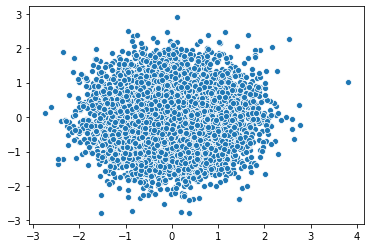

In [4]:
# Extract embeddings
book_embeddings = model.item_embedding
book_emb_weights = model.item_embedding.weight.detach().numpy()
#Visualizing Embedding weights
from sklearn.decomposition import PCA
import seaborn as sns
pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_emb_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

Interestingly enough, the outliers stil exist, but with more weights apparent, they seem to be stil as much as in the other two models, while a good chunk of the weights is in the middle

In [5]:
book_emb_weights = book_emb_weights / np.linalg.norm(book_emb_weights, axis = 1).reshape((-1, 1))
book_emb_weights[0][:10]
np.sum(np.square(book_emb_weights[0]))

1.0000001

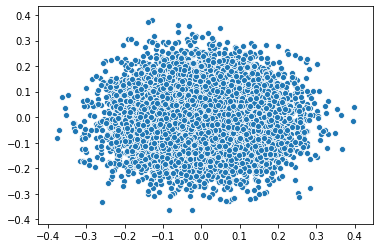

In [6]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_emb_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

## Evaluation of the System
In the following section, I will evaluate the results generated by the Neural Recommender on the test dataset. First, we will analyze the regression loss, which will give us a floating point value for how much we are off on average for our predicted ratings, but before that I will, as done for the other two models, print out a short summary of the predictions

In [8]:
import sklearn
from sklearn.metrics import classification_report
true_ratings = test_ratings.rating
print(sklearn.metrics.classification_report(true_ratings, test_predictions, labels=[1, 2, 3, 4, 5], zero_division=0))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1792
           2       0.07      0.02      0.03      6259
           3       0.25      0.40      0.31     24420
           4       0.37      0.52      0.43     36094
           5       0.29      0.06      0.10     29811

   micro avg       0.31      0.31      0.31     98376
   macro avg       0.19      0.20      0.17     98376
weighted avg       0.29      0.31      0.27     98376



In [9]:
# counting the total amount of predicted labels on the test data
r1_count = test_predictions.count(1)
r2_count = test_predictions.count(2)
r3_count = test_predictions.count(3)
r4_count = test_predictions.count(4)
r5_count = test_predictions.count(5)

print("Total count of rating class 1 predicted: {}".format(r1_count))
print("Total count of rating class 2 predicted: {}".format(r2_count))
print("Total count of rating class 3 predicted: {}".format(r3_count))
print("Total count of rating class 4 predicted: {}".format(r4_count))
print("Total count of rating class 5 predicted: {}".format(r5_count))

Total count of rating class 1 predicted: 0
Total count of rating class 2 predicted: 1549
Total count of rating class 3 predicted: 39652
Total count of rating class 4 predicted: 50683
Total count of rating class 5 predicted: 6455


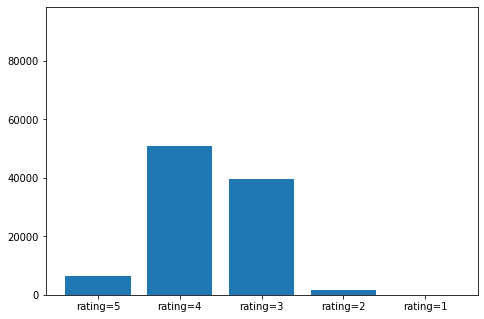

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ymax = len(test_ratings.rating)
ymin = 0
ax.set_ylim([ymin,ymax])
ratings = ['rating=5', 'rating=4', 'rating=3', 'rating=2', 'rating=1']
counts = [r5_count, r4_count, r3_count, r2_count, r1_count]
ax.bar(ratings,counts)
plt.show()

In [11]:
regression_loss_nn = regression_loss(test_predictions)
print("The regression loss for the Neural Recommender on the test data is: {}".format(regression_loss_nn))

The regression loss for the Neural Recommender on the test data is: 0.9159957713263398


So, on average, the system is about 0.91 off when predicting the ratings for the users and items on the test data, which is a vast improvement over the regression loss of the other two models. There is still room for improvement and adjustment, however, but the model generally does a better job at preventing overfitting.

Next, we will take a closer look at how much the ratings are actually off from their actual values:

In [13]:
#First, we will analyze how many ratings are off by one
class_loss = classification_loss(test_predictions, diff=1)
print("Total amount of correctly predicted ratings: {}".format(len(test_ratings.rating) - class_loss[0]))
print("Total amount of incorrectly predicted ratings: {}".format(class_loss[0]))
print("Accuracy of the model in percent: {:.2f}%".format(class_loss[1]))
print("Predictions off by one: {}".format(class_loss[2]))
print("Percentage of ratings off by one out of all the test data: {:.2f}%".format(class_loss[3]*100))
print("Percentage of ratings off by one out of incorrectly predicted ratings: {:.2f}%".format(class_loss[4]*100))

Total amount of correctly predicted ratings: 30446
Total amount of incorrectly predicted ratings: 67930
Accuracy of the model in percent: 30.95%
Predictions off by one: 47805
Percentage of ratings off by one out of all the test data: 48.59%
Percentage of ratings off by one out of incorrectly predicted ratings: 70.37%


The notion that the neural model does seem to make a better job at preventing overfitting is underlined by these values. The total accuracy of the dataset is roughly 31% which is clear improvement over both the previous models, an the ratings that are off only by one rating are also significantly better, meaning that even in the case that the model failed to predict the true rating, it still managed to not mess it up completely.

In [14]:
# Now we analyze the ratings off by two
class_loss_two = classification_loss(test_predictions, diff=2)
print("Predictions off by two: {}".format(class_loss_two[2]))
print("Percentage of ratings off by two out of all the test data: {:.2f}%".format(class_loss_two[3]*100))
print("Percentage of ratings off by two out of incorrectly predicted ratings: {:.2f}%".format(class_loss_two[4]*100))

Predictions off by two: 18173
Percentage of ratings off by two out of all the test data: 18.47%
Percentage of ratings off by two out of incorrectly predicted ratings: 26.75%


In [18]:
# Ratings off by three
class_loss_three = classification_loss(test_predictions, diff=3)
print("Predictions off by three: {}".format(class_loss_three[2]))
print("Percentage of ratings off by three out of all the test data: {:.2f}%".format(class_loss_three[3]*100))
print("Percentage of ratings off by three out of incorrectly predicted ratings: {:.2f}%".format(class_loss_three[4]*100))

Predictions off by three: 1849
Percentage of ratings off by three out of all the test data: 1.88%
Percentage of ratings off by three out of incorrectly predicted ratings: 2.72%


In [19]:
# Ratings off by four 
class_loss_four = classification_loss(test_predictions, diff=4)
print("Predictions off by four: {}".format(class_loss_four[2]))
print("Percentage of ratings off by four out of all the test data: {:.2f}%".format(class_loss_four[3]*100))
print("Percentage of ratings off by four out of incorrectly predicted ratings: {:.2f}%".format(class_loss_four[4]*100))

Predictions off by four: 101
Percentage of ratings off by four out of all the test data: 0.10%
Percentage of ratings off by four out of incorrectly predicted ratings: 0.15%


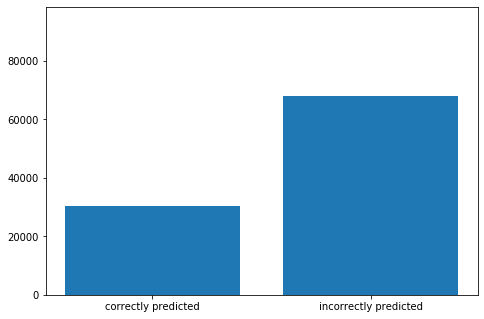

In [20]:
# Plotting the data to show difference between correctly and incorrectly predicted ratings
fig1 = plt.figure()
ax1 = fig1.add_axes([0,0,1,1])
ymax = len(test_ratings.rating)
ymin = 0
ax1.set_ylim([ymin,ymax])
correct = ymax - class_loss[0]
offs = ['correctly predicted', 'incorrectly predicted']
counts = [correct, class_loss[0]]
ax1.bar(offs,counts)
plt.show()

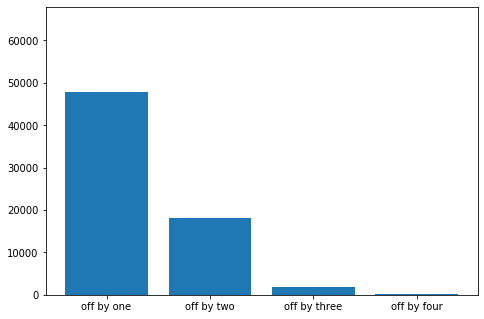

In [21]:
# Plotting the amount of ratings that were off by 1, 2, 3, 4 respectively out of all incorrectly predicted ratings
fig2 = plt.figure()
ax2 = fig2.add_axes([0,0,1,1])
ymax = class_loss[0]
ymin = 0
ax2.set_ylim([ymin,ymax])
offs = ['off by one', 'off by two', 'off by three', 'off by four']
counts = [class_loss[2],class_loss_two[2], class_loss_three[2], class_loss_four[2]]
ax2.bar(offs,counts)
plt.show()

In [25]:
# Recalls 
recall_five = recall_per(test_predictions, 5)
recall_four = recall_per(test_predictions, 4)
recall_three = recall_per(test_predictions, 3)
recall_two = recall_per(test_predictions, 2)
recall_one = recall_per(test_predictions, 1)
recall_total = recall_macro_avg(test_predictions)

print("Recall for rating 5: {:.3f}%".format(recall_five*100))
print("Recall for rating 4: {:.3f}%".format(recall_four*100))
print("Recall for rating 3: {:.3f}%".format(recall_three*100))
print("Recall for rating 2: {:.3f}%".format(recall_two*100))
print("Recall for rating 1: {:.3f}%".format(recall_one*100))
print("Total macro averaged recall: {:.3f}%".format(recall_total*100))

Recall for rating 5: 6.327%
Recall for rating 4: 51.546%
Recall for rating 3: 40.352%
Recall for rating 2: 1.614%
Recall for rating 1: 0.000%
Total macro averaged recall: 19.968%


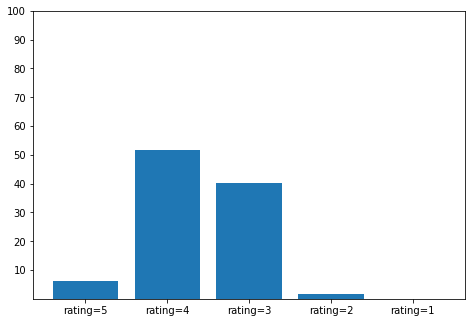

In [27]:
# Plotting the recall
fig3 = plt.figure()
ax3 = fig3.add_axes([0,0,1,1])
ticks = [10,20,30,40,50,60, 70, 80, 90, 100]
ax3.set_yticks(ticks)
ymax = 100
ymin = 0
ax3.set_ylim([ymin,ymax])
ratings = ['rating=5', 'rating=4', 'rating=3', 'rating=2', 'rating=1']
counts = [recall_five*100, recall_four*100, recall_three*100, recall_two*100, recall_one*100]
ax3.bar(ratings,counts)
plt.show()

As it's visible from the data of the recall metric, the system wasn't quite able to succesfully predict the corresponding ground truths from the test data. While the recall for rating class 4 and 3 still seem somewhat acceptable, the recall for the other 3 rating classes, especially class 1 with a value of 0, are very small, which indicated that the system struggled greatly with correctly predicting these ratings. It is worth noting that especially the lower rating classes of 1 and 2 were problematic for the system. One might think about different reasons as to why the system failed here so much, one potential reason could be that they are relatively rare among the rating column of the test ratings. In order to verify this, I will analyze the rating column of the test data:

In [28]:
test_ratings.rating.value_counts()

4    36094
5    29811
3    24420
2     6259
1     1792
Name: rating, dtype: int64

As it can be seen, the rating classes 1 and 2 are indeed relatively rare compared to the other rating classes of the test dataset. As a consequence, the system might have seen to few instances of these rating classes in order to properly learn and predict them.<br>
Now I will analyze the **precision** for each rating class and the macro averaged precision: 

In [30]:
##Analyzing precisions
precision_five = precision_per(test_predictions, 5)
precision_four = precision_per(test_predictions, 4)
precision_three = precision_per(test_predictions, 3)
precision_two = precision_per(test_predictions, 2)
precision_one = precision_per(test_predictions, 1)
precision_total = precision_macro_avg(test_predictions)

print("Precision for rating 5: {:.3f}%".format(precision_five*100))
print("Precision for rating 4: {:.3f}%".format(precision_four*100))
print("Precision for rating 3: {:.3f}%".format(precision_three*100))
print("Precision for rating 2: {:.3f}%".format(precision_two*100))
print("Precision for rating 1: {:.3f}%".format(precision_one*100))
print("Total macro averaged precision: {:.3f}%".format(precision_total*100))

Rating 1 wasn't predicted
Rating 1 wasn't predicted
Precision for rating 5: 29.218%
Precision for rating 4: 36.709%
Precision for rating 3: 24.851%
Precision for rating 2: 6.520%
Precision for rating 1: 0.000%
Total macro averaged precision: 19.460%


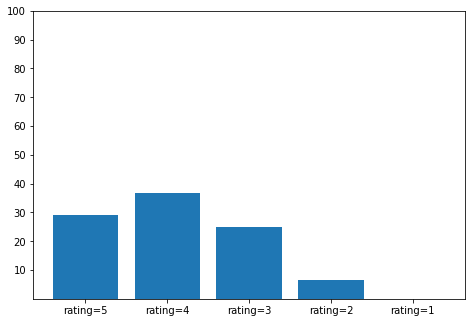

In [31]:
##Plotting precisions
# Plotting the recall
fig4 = plt.figure()
ax4 = fig4.add_axes([0,0,1,1])
ax4.set_yticks(ticks)
ymax = 100
ymin = 0
ax4.set_ylim([ymin,ymax])
ratings = ['rating=5', 'rating=4', 'rating=3', 'rating=2', 'rating=1']
counts = [precision_five*100, precision_four*100, precision_three*100, precision_two*100, precision_one*100]
ax4.bar(ratings,counts)
plt.show()

As it can be seen from both precision and recall measures, rating class 4 provided the best results from the system on the test data, because it's the most frequent rating among the ratings of the test dataset. Unlike recall, the precision for rating class 5 provides better results, while the precision for rating class 3 ranks slightly below. Again, due to their insignificantly rare occurences in the test data ratings, one and 2 provide dismal results, which ultimately effects the total precision so much that an exception handling for *ZeroDivisionError* was necessary because of the precision of 0 for rating 1.<br>
Analyzing the f-measure for each rating and in total:

In [32]:
# I had to use sk-learns f1 score function here since apparently I had a bug in my code in the metrics file
# f-measure, the data can be seen at the bottom of the notbook in the summary 
import sklearn
from sklearn.metrics import f1_score


f_five =  0.11
f_four = 0.43
f_three = 0.31
f_two = 0.02
f_one = 0.00 #f_measure_per function will cause a ZeroDivisionError
# because of this, I will add up the percentages and divide them  by the number of output (i.e. rating) classes
f_total = f1_score(test_ratings.rating, test_predictions, average='macro')
f1_total_weighted = f1_score(test_ratings.rating, test_predictions, average='weighted')
f1_total_micro = f1_score(test_ratings.rating, test_predictions, average='micro')


print("F1-measure for rating class 5: {:.3f}%".format(f_five*100))
print("F1-measure for rating class 4: {:.3f}%".format(f_four*100))
print("F1-measure for rating class 3: {:.3f}%".format(f_three*100))
print("F1-measure for rating class 2: {:.3f}%".format(f_two*100))
print("F1-measure total for the test set macro-averaged: {:.3f}%".format(f_total*100))
print("Weighted F1-measure for the test set {:.3f}%".format(f1_total_weighted*100))
print("Weighted F1-measure for the test set micro-averaged: {:.3f}%".format(f1_total_micro*100))

F1-measure for rating class 5: 11.000%
F1-measure for rating class 4: 43.000%
F1-measure for rating class 3: 31.000%
F1-measure for rating class 2: 2.000%
F1-measure total for the test set macro-averaged: 14.438%
Weighted F1-measure for the test set 26.684%
Weighted F1-measure for the test set micro-averaged: 30.949%


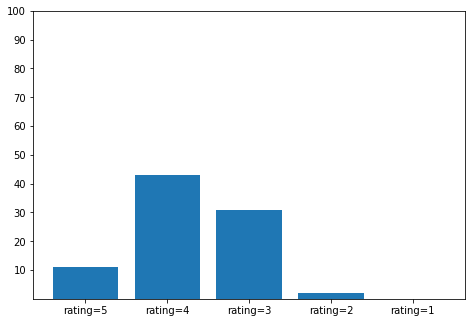

In [33]:
# Plotting the f-measures

fig5 = plt.figure()
ax5 = fig5.add_axes([0,0,1,1])
ax5.set_yticks(ticks)
ymax = 100
ymin = 0
ax5.set_ylim([ymin,ymax])
ratings = ['rating=5', 'rating=4', 'rating=3', 'rating=2', 'rating=1']
counts = [f_five*100, f_four*100, f_three*100, f_two*100, 0]
ax5.bar(ratings,counts)
plt.show()

Unsurprisingly, the f-measure for rating equals to zero since both its precision and recall were 0, while the f-measure for rating 4 is the highest, with 5 and 3 following each other closely. This further proves that a recommender system needs plenty of observations for each output class in order to predict them correctly, as rating class seems to be an output class with which the system has struggled greatly due to its lack of occurence on the test data.<br>
Lastly, I will analyze the accuracy for each rating class

## Conclusion
Neural Recommenders provide Neural Networks architecture and NN frameworks for building recommender systems and thus provide a Machine Learning tool for recommender systems and recommending items to users. Unsurprisingly, Neural Network models surpass simpler yet still somewhat effective Matrix Factorization models, and with even greater CPU performance and more epochs, this model could be further improved. One significant advantage of the NN architecture is that it doesn't require the user to normalize the ratings and provides already normalized ratings, which saves a lot of computation. Since this model is based on explicit Collaborative Filtering and thus relies on the data and especially the occurence of certain classes (which can be a problem as evidenced by rating class 1), it would be interesting to see how well Neural Network architecture based recommender systems perform with the method of **item-based filtering**, which takes into account things such as *viewing time, search pattern, clicking pattern* etc, as I can imagine that a Neural Network, with the technical tools to perform such observations, could learn these factors very efficiently and provide accurate recommendations and ratings accordingly. The last thing is to note that while this result may seem unsatisfying, it is still worth noting that this model can further be improved, extended, adjusted, and given more time and potentially even GPU power to learn and train better on trainings dataset and thus perform better on unseen data. Neural Networks provide for a great opportunity in experimentally handling the task of user recommendations. One last thing to note is that all three models suffer from the very nature of Collaborative filtering, in that they tend to recommend the most popular items on a given platform. While this fulfills the task of Collaborative filtering, it actually might not fulfill the expectations of some users whose tastes go against the mainstream.